In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Greenland = pd.read_excel(filepath, sheet_name='Greenland-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Greenland)
fp.date_time(Greenland)

,Extent,Date
0,1076123.146,1979-01-01
1,1099248.063,1979-02-01
2,1036964.901,1979-03-01
3,958927.937,1979-04-01
4,823812.694,1979-05-01
...,...,...
533,721350.515,2023-06-01
534,459033.164,2023-07-01
535,282045.909,2023-08-01
536,270397.608,2023-09-01


In [5]:
scaler = MinMaxScaler()
Greenland['Extent'] = scaler.fit_transform(Greenland['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 8
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Greenland['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((519, 12, 1), (519,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Greenland_model_LT8/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 8s 101ms/step - loss: 0.2383 - root_mean_squared_error: 0.4882 - val_loss: 0.0674 - val_root_mean_squared_error: 0.2596
Epoch 2/50
53/53 [==============================] - 5s 102ms/step - loss: 0.0658 - root_mean_squared_error: 0.2566 - val_loss: 0.0344 - val_root_mean_squared_error: 0.1853
Epoch 3/50
53/53 [==============================] - 5s 94ms/step - loss: 0.0460 - root_mean_squared_error: 0.2145 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1815
Epoch 4/50
53/53 [==============================] - 1s 21ms/step - loss: 0.0445 - root_mean_squared_error: 0.2109 - val_loss: 0.0331 - val_root_mean_squared_error: 0.1820
Epoch 5/50
53/53 [==============================] - 1s 19ms/step - loss: 0.0414 - root_mean_squared_error: 0.2036 - val_loss: 0.0356 - val_root_mean_squared_error: 0.1886
Epoch 6/50
53/53 [==============================] - 5s 101ms/step - loss: 0.0376 - root_mean_squared_error: 0.1939 - val_loss: 0.0261 - val_roo

53/53 [==============================] - 2s 32ms/step - loss: 0.0140 - root_mean_squared_error: 0.1182 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1123
Epoch 39/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0127 - root_mean_squared_error: 0.1127 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1215
Epoch 40/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0127 - root_mean_squared_error: 0.1128 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1169
Epoch 41/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0132 - root_mean_squared_error: 0.1151 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1230
Epoch 42/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0120 - root_mean_squared_error: 0.1097 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1183
Epoch 43/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0128 - root_mean_squared_error: 0.1133 - val_loss: 0.0135 - val_root_mean_sq

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

2.5691935936609904 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

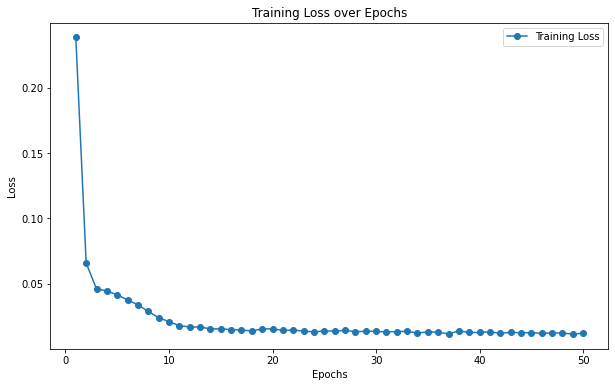

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

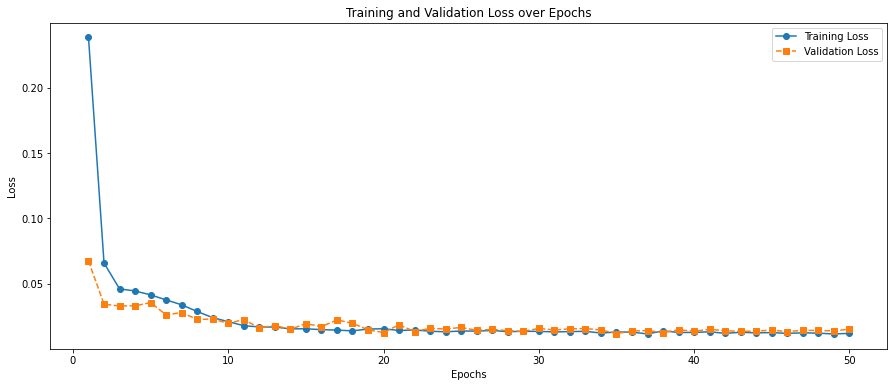

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Greenland_model_LT8/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 11ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.1063690276292121
MAE : 0.08287825388473688


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,565776.625000,584596.262
1,634792.312500,584830.109
2,674394.250000,641562.292
3,682254.250000,734946.437
4,660358.312500,777596.225
5,600107.187500,687087.673
6,522150.406250,622337.816
7,445345.875000,467232.074
8,380732.156250,297495.641
9,346090.343750,268909.854


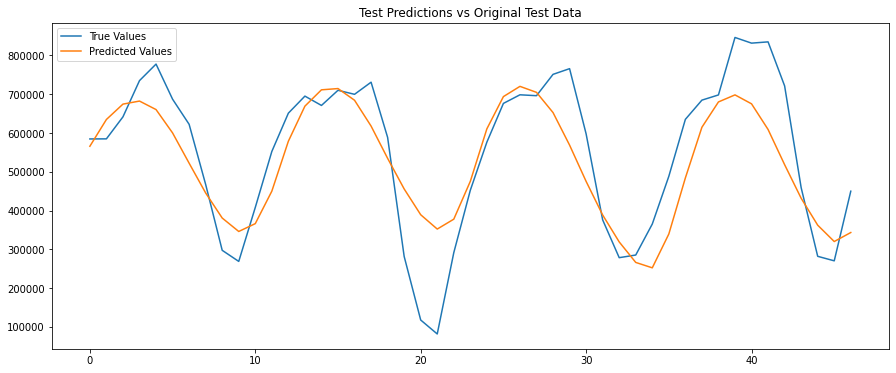

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 15ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

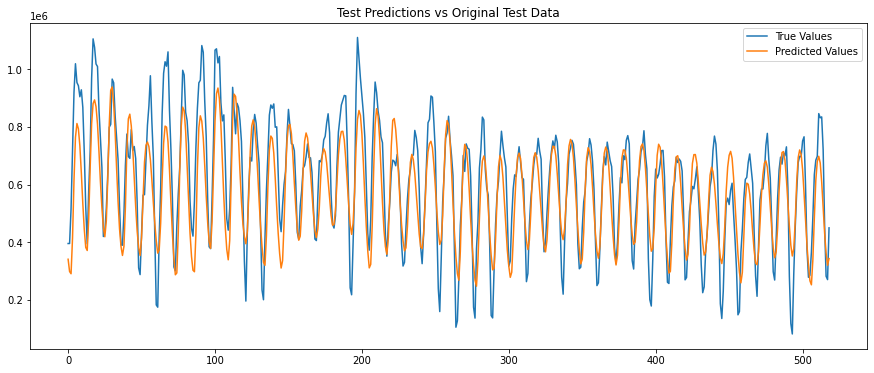

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()